# TM10007 Assignment template

In [ ]:
# Run this to use from colab environment
#!git clone https://github.com/BrianvanWinden/TM10007_Group_13.git
    #!unzip "/content/TM10007_Group_13/ecg/ecg_data.zip"
    # import pandas as pd 

    # data = pd.read_csv("ecg_data.csv") 

    # print(data.head())

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [16]:
# General packages
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn import datasets as ds
from scipy.stats import randint
from zipfile import ZipFile
from scipy import stats


# Classifiers and kernels
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn import preprocessing, metrics

# Regularization
from sklearn.linear_model import Lasso, RidgeClassifier
from sklearn.feature_selection import SelectFromModel

# Model selection
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split, learning_curve, ShuffleSplit, StratifiedKFold

from sklearn.pipeline import Pipeline


## Definition of functions
- Preprocessing data
- Learning curves
- Colorplots
- Evaluation (confusion matrix)
- Cross-validation pipeline

In [13]:

# Data loading functions

def preprocessing_data(data):
    data_points= data.drop(['label'], axis=1).to_numpy()
    data_labels= data['label'].to_numpy()

    sick = sum(data_labels) # 146 

    # Missing values
    missing_values = data.isna().sum()
    number_missing_values = missing_values.astype(bool).sum(axis=0)

    # checking for outliers
    z = np.abs(stats.zscore(data))
    x = np.where(z>3)
    #print(len(x[1])) # number of outliers -> robust scaler

    # Splitting
    # lecture 2.3 20% test set, and 15% van de train set is validatie
    x_train_val, x_test, y_train_val, y_test = train_test_split(data_points, data_labels, test_size=0.2)
    x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.15)

    #Scaling
    # Robust scaler omdat er mogelijk sprake is van outliers, median wordt er dan vanaf gehaald en niet de mean die wordt beinvloed door de outliers.
    scaler = preprocessing.RobustScaler()
    scaler.fit(x_train)
    x_train_val_scaled = scaler.transform(x_train_val)
    x_train_scaled = scaler.transform(x_train)
    x_val_scaled = scaler.transform(x_val)
    x_test_scaled = scaler.transform(x_test)

    #PCA
    pca = PCA(n_components=2)
    pca = pca.fit(x_train_scaled)
    x_train_val_trans = pca.transform(x_train_val_scaled)
    x_train_trans = pca.transform(x_train_scaled)
    x_val_trans = pca.transform(x_val_scaled)
    x_test_trans = pca.transform(x_test_scaled)
    explained_variance = pca.explained_variance_ratio_
    # two pc's had a combined explained variance of 0.85 so chosing 2 pc's

    # x_train_trans_df = pd.DataFrame(x_train_trans, columns=['PC1', 'PC2', 'PC3', 'PC4'])
    # y_train_df = pd.DataFrame(y_train, columns=['label'])
    # xy_plot = pd.concat([x_train_trans_df, y_train_df], axis=1)
    # pc_pairplot = sns.pairplot(xy_plot, hue='label', palette='tab10')
    
    return x_train_trans, y_train, x_test_trans, y_test, x_val_trans, y_val, x_train_val_trans, y_train_val


# Learning curve

def plot_learning_curve(estimator, title, X, y, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores  = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")
    return plt


# Colorplots features and boundaries

def colorplot(clf, ax, x, y, h=100, precomputer=None):
    '''
    Overlay the decision areas as colors in an axes.
    
    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    features = np.c_[xx.ravel(), yy.ravel()]
    if precomputer is not None:
        if type(precomputer) is RBFSampler:
            features = precomputer.transform(features)
        elif precomputer is rbf_kernel:
            features = rbf_kernel(features, X)
            
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(features)
    else:
        Z = clf.predict_proba(features)
    if len(Z.shape) > 1:
        Z = Z[:, 1]
    
    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm


# Evaluation confusion matrix

def evaluation(y_val, y_pred, title = 'Confusion Matrix'):
    cm = confusion_matrix(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    print('Recall: ', recall)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('F1: ', f1)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws=    {'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show()


# Cross-validation pipeline

def cross_validate(classifier, cv, x_train_trans, y_train_trans, x_val_trans, y_val_trans):

    pipeline = Pipeline(steps=[
        ('preprocess', preprocessing_data),
        ('classifier', classifier)
    ])
    train_acc = []
    test_acc = []
    for train_ind, val_ind in cv.split(X_train, y_train):
        X_t, y_t = X_train.iloc[train_ind], y_train[train_ind]
        pipeline.fit(X_t, y_t)
        y_hat_t = pipeline.predict(X_t)
        train_acc.append(accuracy_score(y_t, y_hat_t))
        X_val, y_val = X_train.iloc[val_ind], y_train[val_ind]
        y_hat_val = pipeline.predict(X_val)
        test_acc.append(accuracy_score(y_val, y_hat_val))
    print(evaluation(y_val, y_hat_val))
    print('Training Accuracy: {}'.format(np.mean(train_acc)))
    print('\n')
    print('Validation Accuracy: {}'.format(np.mean(test_acc)))
    print('\n')



In [24]:
# Data
from ecg.load_data import load_data
data = load_data()

x_train_trans, y_train, x_test_trans, y_test, x_val_trans, y_val, x_train_val_trans, y_train_val = preprocessing_data(data)

# X = x_train_trans
# Y = y_train

# Classifiers
svmlin = SVC(kernel='linear', gamma='scale')
svmrbf = SVC(kernel='rbf', gamma='scale')
svmpoly = SVC(kernel='poly', degree=3, gamma='scale')
clsfs = [KNeighborsClassifier(), RandomForestClassifier(), svmlin, svmpoly, svmrbf]
classifier = svmlin


In [6]:
# # Load data and create classifiers

# # Data
# from ecg.load_data import load_data
# data = load_data()

# x_train_trans, y_train, x_test_trans, y_test = preprocessing_data(data)

# X = x_train_trans
# Y = y_train

# # Classifiers
# # param_distributions_svm = {}
# # param_distributions = {'n_estimators': randint(1, 400)}
# # svmlin = RandomizedSearchCV(SVC(kernel='linear', gamma='scale'), param_distributions_svm, cv=5, n_iter=20, random_state=42)
# # svmrbf = RandomizedSearchCV(SVC(kernel='rbf', gamma='scale'), param_distributions_svm, cv=5, n_iter=20, random_state=42)
# # svmpoly = RandomizedSearchCV(SVC(kernel='poly', degree=3, gamma='scale'), param_distributions_svm, cv=5, n_iter=20, random_state=42)
# # RF = RandomizedSearchCV(RandomForestClassifier(), param_distributions, cv=5, n_iter=20, random_state=42)
# # LDA = RandomizedSearchCV(LinearDiscriminantAnalysis(), param_distributions, cv=5, n_iter=20, random_state=42)
# # KNN = RandomizedSearchCV(KNeighborsClassifier(), param_distributions, cv=5, n_iter=20, random_state=42)
# # clsfs = [svmlin,svmrbf,svmpoly,RF,LDA,KNN]
# svmlin = SVC(kernel='linear', gamma='scale')
# svmrbf = SVC(kernel='rbf', gamma='scale')
# svmpoly = SVC(kernel='poly', degree=3, gamma='scale')
# clsfs = [KNeighborsClassifier(), RandomForestClassifier(), svmlin, svmpoly, svmrbf]



In [18]:
# Learning Curve

X = x_train_trans
Y = y_train

num = 0
fig = plt.figure(figsize=(24,8*len(clsfs)))
ax = fig.add_subplot(7, 3, num + 1)
ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y, 
           s=25, edgecolor='k', cmap=plt.cm.Paired)

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
num = 1
for clf in clsfs:
    # Split data in training and testing
    title = str(clf)
    ax = fig.add_subplot(7, 3, num + 1)
    plot_learning_curve(clf, title, X, Y, ax, ylim=(0.3, 1.01), cv=cv)
    num += 1

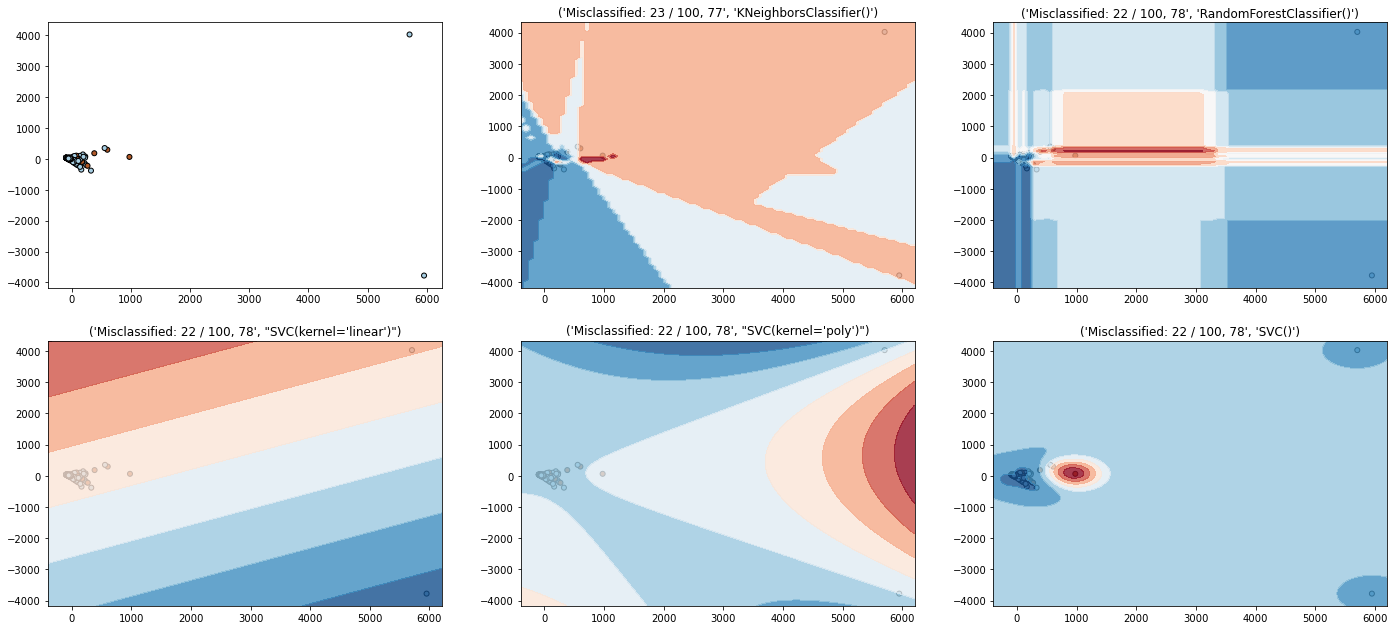

In [25]:
# Plot classifications

X = x_train_trans
Y = y_train

num = 0
fig = plt.figure(figsize=(24,8*len(clsfs)))
ax = fig.add_subplot(7, 3, num + 1)
ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y, 
           s=25, edgecolor='k', cmap=plt.cm.Paired)

num = 1
for clf in clsfs:
    clf.fit(X, Y)
    ax = fig.add_subplot(7, 3, num + 1)
    ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
        s=25, edgecolor='k', cmap=plt.cm.Paired)
    colorplot(clf, ax, X[:, 0], X[:, 1])
    y_pred = clf.predict(x_val_trans)
    accuracy = metrics.accuracy_score(y_val, y_pred)
    # best = clf.best_estimator_
    t = ('Misclassified: %d / %d, %d' % ((y_val != y_pred).sum(), x_val_trans.shape[0], accuracy*100), str(clf))
    ax.set_title(t)
    num += 1




Best classifier: k=19
Best classifier: k=17
Best classifier: k=1
Best classifier: k=1
Best classifier: k=1
Best classifier: k=1
Best classifier: k=17
Best classifier: k=23
Best classifier: k=1
Best classifier: k=25
The optimal N=9


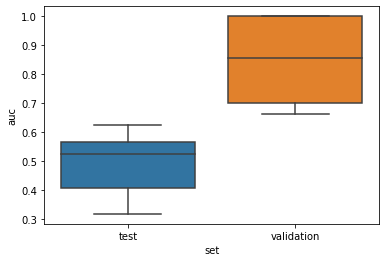

In [26]:

# Create a 20 fold stratified CV iterator
cv_20fold = StratifiedKFold(n_splits=10)
results = []
best_n_neighbors = []

# Loop over the folds
for validation_index, test_index in cv_20fold.split(x_train_val_trans, y_train_val):
    # Split the data properly
    X_validation = x_train_val_trans[validation_index]
    y_validation = y_train_val[validation_index]
    
    X_test = x_train_val_trans[test_index]
    y_test = y_train_val[test_index]
    
    # Create a grid search to find the optimal k using a gridsearch and 10-fold cross validation
    # Same as above
    parameters = {"n_neighbors": list(range(1, 26, 2))}
    knn = KNeighborsClassifier()
    cv_10fold = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(knn, parameters, cv=cv_10fold, scoring='roc_auc')
    grid_search.fit(X_validation, y_validation)
    
    # Get resulting classifier
    clf = grid_search.best_estimator_
    print(f'Best classifier: k={clf.n_neighbors}')
    best_n_neighbors.append(clf.n_neighbors)
    
    # Test the classifier on the test data
    probabilities = clf.predict_proba(X_test)
    scores = probabilities[:, 1]
    
    # Get the auc
    auc = metrics.roc_auc_score(y_test, scores)
    results.append({
        'auc': auc,
        'k': clf.n_neighbors,
        'set': 'test'
    })
    
    # Test the classifier on the validation data
    probabilities_validation = clf.predict_proba(X_validation)
    scores_validation = probabilities_validation[:, 1]
    
    # Get the auc
    auc_validation = metrics.roc_auc_score(y_validation, scores_validation)
    results.append({
        'auc': auc_validation,
        'k': clf.n_neighbors,
        'set': 'validation'
    })
    
# Create results dataframe and plot it
results = pd.DataFrame(results)
sns.boxplot(y='auc', x='set', data=results)

optimal_n = int(np.median(best_n_neighbors))
print(f"The optimal N={optimal_n}")

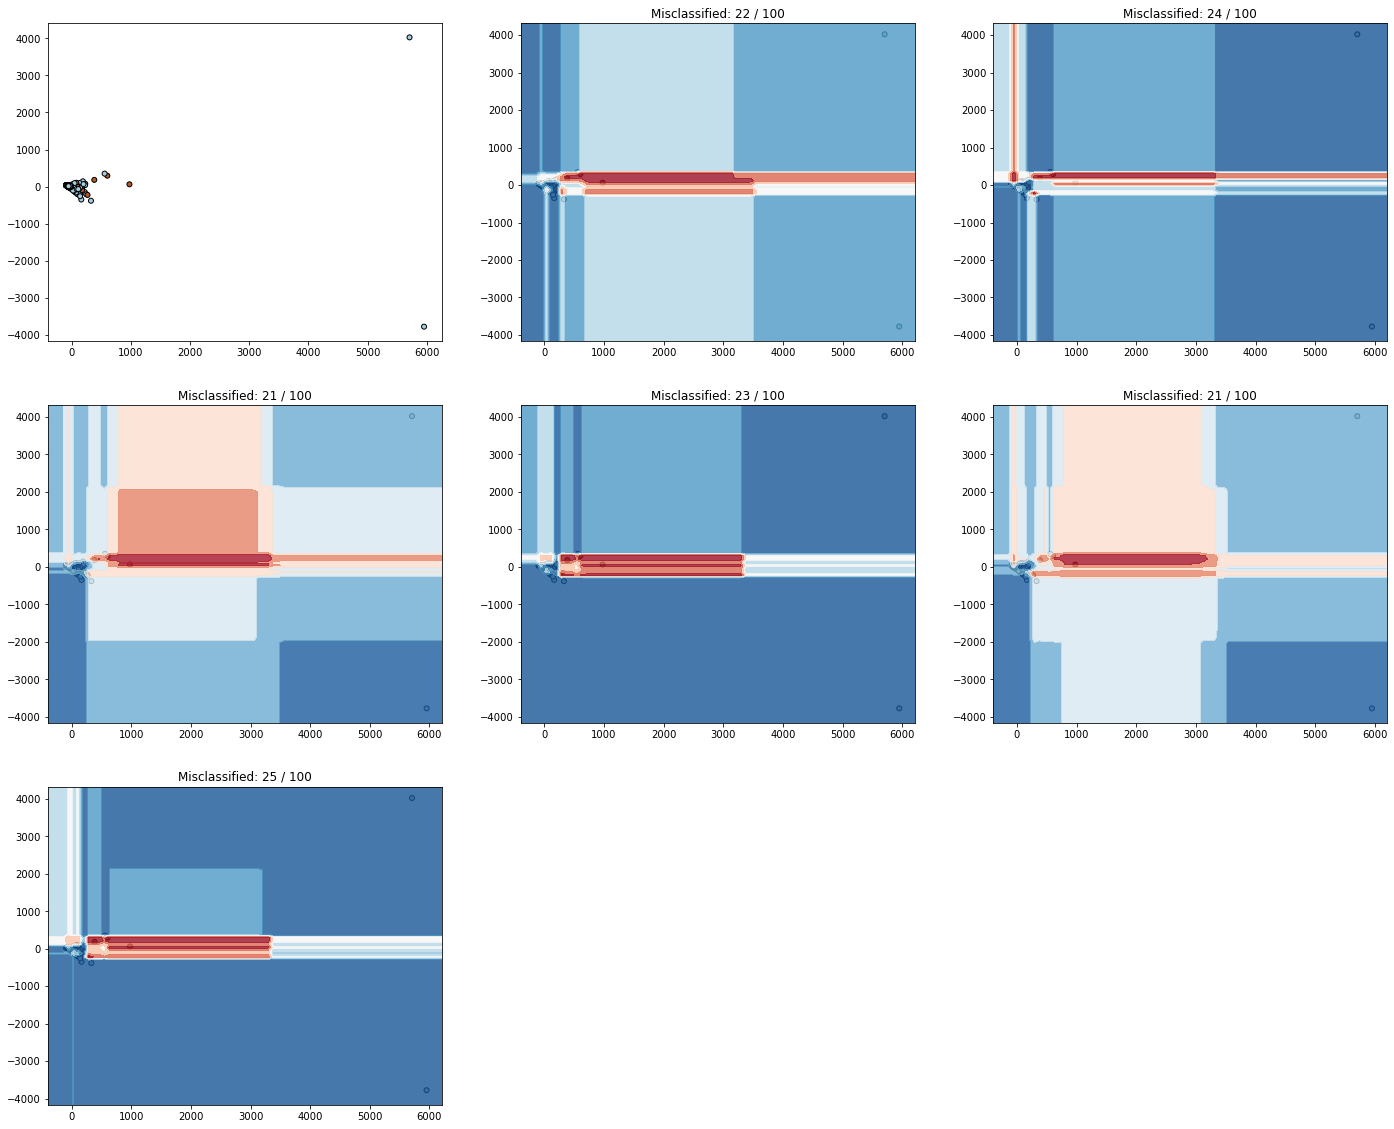

In [27]:

X = x_train_trans
Y = y_train

clsfs = [RandomForestClassifier(n_estimators=5, bootstrap=True),
         RandomForestClassifier(n_estimators=5, bootstrap=False),
         RandomForestClassifier(n_estimators=50, bootstrap=True),
         RandomForestClassifier(n_estimators=50, bootstrap=False),
         RandomForestClassifier(n_estimators=100, bootstrap=True),
         RandomForestClassifier(n_estimators=100, bootstrap=False)]

# First make plot without classifiers:
num = 0
fig = plt.figure(figsize=(24,8*len(clsfs)))
ax = fig.add_subplot(7, 3, num + 1)
ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
    s=25, edgecolor='k', cmap=plt.cm.Paired)
num += 1
    
# Now use the classifiers on all datasets
for clf in clsfs:
    clf.fit(X, Y)
    ax = fig.add_subplot(7, 3, num + 1)
    ax.scatter(X[:, 0], X[:, 1], marker='o', c=Y,
        s=25, edgecolor='k', cmap=plt.cm.Paired)
    colorplot(clf, ax, X[:, 0], X[:, 1])
    y_pred = clf.predict(x_val_trans)
    t = ("Misclassified: %d / %d" % ((y_val != y_pred).sum(), x_val_trans.shape[0]))
    ax.set_title(t)
    num += 1
